## Pre Processing

In [ ]:
from os import makedirs 
from os import listdir
from shutil import copyfile
from random import seed
from random import random

In [ ]:
dataset_home = 'flowers/'

In [ ]:
subdirs = ['train/','test/']
labeldirs = ['daisy/','dandelion/','roses/','sunflowers/','tulips/']

In [ ]:
for subdir in subdirs:
    for labldir in labeldirs:
        newdir = dataset_home + '/' + subdir + labldir
        makedirs(newdir,exist_ok = True)

In [ ]:
seed(1)
val_ratio = 0.20

In [ ]:
src_directory = 'flower_photos/'

In [ ]:
for labels in labeldirs:
    for file in listdir(src_directory+labels):
        src = src_directory + '/' + labels + '/' + file
        dst_dir = 'train/'
        if random() < val_ratio:
            dst_dir = 'test/'
        dst = dataset_home + dst_dir + labels + file
        copyfile(src,dst)  

## Defining Model

In [1]:
import sys
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
def summarize_diagnostics(history):
    #plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    #blue = train, orange = test
    pyplot.plot(history.history['loss'],color='blue',label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    #plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.tight_layout()
    #save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.show()
    pyplot.close()

In [3]:
def define_model_vgg_16():
    # load model
    model = VGG16(include_top=False,input_shape=(224,224,3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128,activation='relu',kernel_initializer='he_uniform')(flat1)
    output = Dense(5,activation='softmax')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs = output)
    #compile model
    opt = SGD(lr=0.001,momentum=0.9)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

In [4]:
def run_model_vgg16():
    model = define_model_vgg_16()
    datagen = ImageDataGenerator(featurewise_center=True)
    datagen.mean = [123.68,116.779,103.939]
    #prepare train and test iterators
    train_it = datagen.flow_from_directory('flowers/train/',
                class_mode='categorical',batch_size=64,target_size=(224,224))
    test_it = datagen.flow_from_directory('flowers/test/',
            class_mode='categorical', batch_size=64, target_size=(224, 224))
    #fit model
    history = model.fit_generator(train_it,steps_per_epoch=len(train_it),
            validation_data=test_it,validation_steps=len(test_it),epochs=10,verbose=1)
    #evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('>%.3f' % (acc*100.0))
    #plot of learning curves
    summarize_diagnostics(history)
    #save model
    model.save('flowers_model.h5')
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    open("converted_model.tflite", "wb").write(tflite_model)

58892288/58889256 [==============================] - 15s 0us/step
Found 2741 images belonging to 5 classes.
Found 929 images belonging to 5 classes.


D:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1847: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
43/43 [==============================] - 466s 11s/step - loss: 10.2520 - accuracy: 0.5128 - val_loss: 0.6825 - val_accuracy: 0.7610
Epoch 2/10
43/43 [==============================] - 433s 10s/step - loss: 0.4839 - accuracy: 0.8224 - val_loss: 0.6276 - val_accuracy: 0.8041
Epoch 3/10
43/43 [==============================] - 434s 10s/step - loss: 0.2507 - accuracy: 0.9095 - val_loss: 0.5843 - val_accuracy: 0.8321
Epoch 4/10
43/43 [==============================] - 437s 10s/step - loss: 0.1057 - accuracy: 0.9606 - val_loss: 0.6732 - val_accuracy: 0.8364
Epoch 5/10
43/43 [==============================] - 441s 10s/step - loss: 0.0651 - accuracy: 0.9742 - val_loss: 0.6680 - val_accuracy: 0.8439
Epoch 6/10
43/43 [==============================] - 424s 10s/step - loss: 0.0462 - accuracy: 0.9832 - val_loss: 0.6937 - val_accuracy: 0.8439
Epoch 7/10
43/43 [==============================] - 424s 10s/step - loss: 0.0392 - accuracy: 0.9843 - val_loss: 0.7309 - val_accuracy: 0.8439
Epoch

D:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1880: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


>84.392


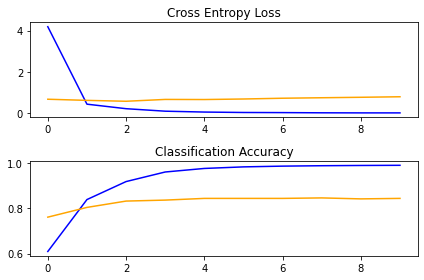

D:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:2342: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
D:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1395: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: C:\Users\metec\AppData\Local\Temp\tmpx1d0ax9w\assets


In [9]:
run_model_vgg16()